# LightGlue Demo
In this notebook we match two pairs of images using LightGlue with early stopping and point pruning.

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
from pathlib import Path

if Path.cwd().name != "LightGlue":
    !git clone --quiet https://github.com/cvg/LightGlue/
    %cd LightGlue
    !pip install --progress-bar off --quiet -e .

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)
images = Path("assets")

/content/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for lightglue (pyproject.toml) ... done


/content/LightGlue/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Load extractor and matcher module
In this example we use SuperPoint features combined with LightGlue.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth
100%|██████████| 4.96M/4.96M [00:00<00:00, 142MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth
100%|██████████| 45.3M/45.3M [00:00<00:00, 263MB/s]


## Easy example
The top image shows the matches, while the bottom image shows the point pruning across layers. In this case, LightGlue prunes a few points with occlusions, but is able to stop the context aggregation after 4/9 layers.

In [5]:
image0 = load_image(images / "IMG_0396.jpg")
image1 = load_image(images / "IMG_0397.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=10)

SyntaxError: invalid syntax (<ipython-input-5-4d70c42808e9>, line 1)

## Difficult example
For pairs with significant viewpoint- and illumination changes, LightGlue can exclude a lot of points early in the matching process (red points), which significantly reduces the inference time.

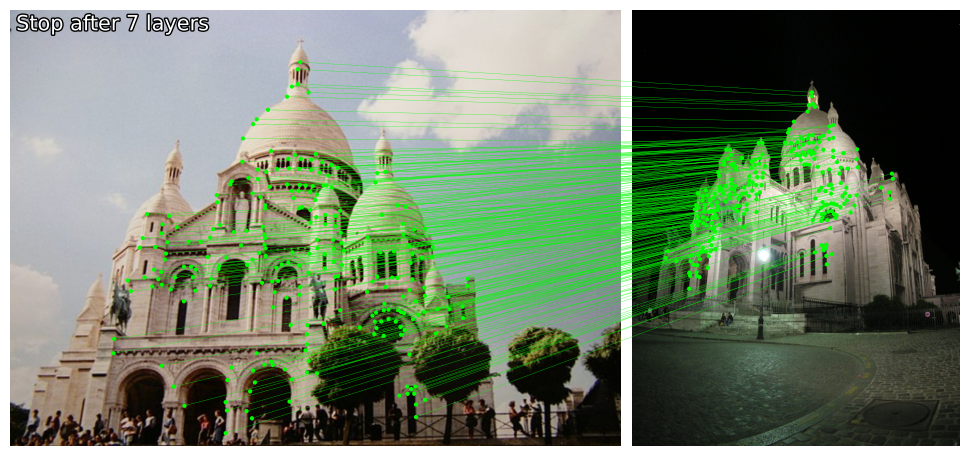

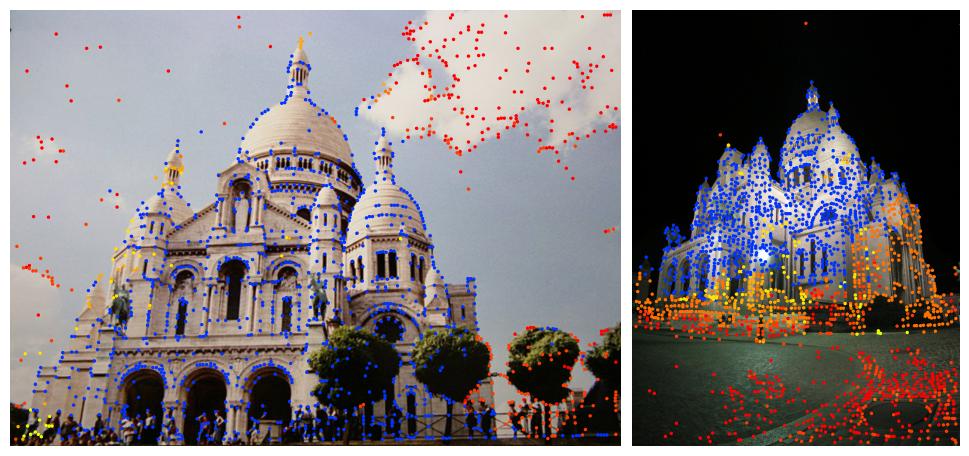

In [4]:
image0 = load_image(images / "sacre_coeur1.jpg")
image1 = load_image(images / "sacre_coeur2.jpg")

feats0 = extractor.extract(image0.to(device))
feats1 = extractor.extract(image1.to(device))
matches01 = matcher({"image0": feats0, "image1": feats1})
feats0, feats1, matches01 = [
    rbd(x) for x in [feats0, feats1, matches01]
]  # remove batch dimension

kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

axes = viz2d.plot_images([image0, image1])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)
viz2d.add_text(0, f'Stop after {matches01["stop"]} layers')

kpc0, kpc1 = viz2d.cm_prune(matches01["prune0"]), viz2d.cm_prune(matches01["prune1"])
viz2d.plot_images([image0, image1])
viz2d.plot_keypoints([kpts0, kpts1], colors=[kpc0, kpc1], ps=6)